<a href="https://colab.research.google.com/github/reiple/ds2_2023_spark/blob/main/E-commerce_%EC%A0%95%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# E-comm Dataset

In [1]:
!wget -q https://archive.apache.org/dist/spark/spark-3.2.4/spark-3.2.4-bin-hadoop3.2.tgz
!tar xf spark-3.2.4-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
%%time
import findspark
findspark.init("/content/spark-3.2.4-bin-hadoop3.2")

CPU times: user 2.54 ms, sys: 98 µs, total: 2.64 ms
Wall time: 2.72 ms


In [3]:
%%time
from pyspark.sql import SparkSession
from datetime import datetime

#spark = SparkSession.builder.master('local[*]').getOrCreate()
#spark
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

CPU times: user 187 ms, sys: 33.7 ms, total: 220 ms
Wall time: 12.4 s


In [4]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Read Dataset

In [5]:
%%time
df = spark.read.option("header", "true") \
                  .option("inferSchema", "true") \
                  .csv([
                        './data/e-comm-toys.csv.gz'
                    ])

print((df.count(), len(df.columns)))

(4115346, 9)
CPU times: user 326 ms, sys: 54.1 ms, total: 380 ms
Wall time: 54.1 s


In [6]:
import numpy as np
import pandas as pd
import plotly.express as px

In [7]:
df.show(5)

+--------------------+----------+----------+-------------------+-------------+------+-----+---------+--------------------+
|          event_time|event_type|product_id|        category_id|category_code| brand|price|  user_id|        user_session|
+--------------------+----------+----------+-------------------+-------------+------+-----+---------+--------------------+
|2019-11-01 00:02:...|      view|   9002778|2053013553140465927|    kids.toys|disney|10.35|566281096|b9b7e3e3-17f9-487...|
|2019-11-01 00:02:...|      view|   9002778|2053013553140465927|    kids.toys|disney|10.35|566281096|b9b7e3e3-17f9-487...|
|2019-11-01 00:02:...|      view|   9002778|2053013553140465927|    kids.toys|disney|10.35|566281096|b9b7e3e3-17f9-487...|
|2019-11-01 00:09:...|      view|   9002778|2053013553140465927|    kids.toys|disney|10.35|544828616|73e4e5d7-dc72-4ad...|
|2019-11-01 00:10:...|      view|   9002778|2053013553140465927|    kids.toys|disney|10.35|544828616|dd25afb4-74d7-487...|
+---------------

In [8]:
%%time
df = df.na.drop()
print((df.count(), len(df.columns)))

(3204556, 9)
CPU times: user 108 ms, sys: 15.2 ms, total: 123 ms
Wall time: 16.2 s


In [9]:
# category_code 확인

df.select('category_code').distinct().collect()

[Row(category_code='kids.toys')]

In [10]:
# brand 확인

import pandas as pd

df.select('brand').distinct().show()

+-----------+
|      brand|
+-----------+
|       tmnt|
|    tuffoni|
|    blaster|
|    keenway|
|     rosato|
|       nerf|
|   avengers|
|     nasbro|
|    trikota|
|robocarpoli|
|     rieker|
|   skechers|
|         mz|
|    sp.lion|
|       jana|
|      rizmo|
| potatohead|
|      fleet|
|    greyder|
| yogasprout|
+-----------+
only showing top 20 rows



In [11]:
# event_type 확인
df.select('event_type').distinct().show()

+----------+
|event_type|
+----------+
|  purchase|
|      view|
|      cart|
+----------+



# Null이 있는 것들 개수
  * brand 컬럼에 910788개는 null이거나 값이 없다.
  * 나머지 컬럼들은 모두 값이 있다.
  * 컬럼명
    * event_time
    * event_type
    * product_id
    * category_id
    * category_code
    * brand
    * price
    * user_id
    * user_session

## Preprocess and Summarize Data

In [12]:
# %%time
df_smartphone = df

In [13]:
%%time
from pyspark.sql.functions import length, col, max, lpad

print(df_smartphone.schema["product_id"].dataType)
print(df_smartphone.schema["category_id"].dataType)
print(df_smartphone.schema["user_id"].dataType)

df_smartphone = df_smartphone.withColumn("product_id", df_smartphone.product_id.cast('string'))
df_smartphone = df_smartphone.withColumn("category_id", df_smartphone.category_id.cast('string'))
df_smartphone = df_smartphone.withColumn("user_id", df_smartphone.user_id.cast('string'))

max_id_len = df_smartphone.withColumn("product_id_len", length(col("product_id")))\
                          .withColumn("category_id_len",length(col("category_id")))\
                          .withColumn("user_id_len",length(col("user_id")))\
                          .groupBy().agg(max("product_id_len"), max("category_id_len"), max("user_id_len")).collect()

len_pid, len_cid, len_uid = max_id_len[0]

df_smartphone = df_smartphone.withColumn("product_id", lpad(df_smartphone.product_id, len_pid, '0'))\
                             .withColumn("category_id", lpad(df_smartphone.category_id, len_cid, '0'))\
                             .withColumn("user_id", lpad(df_smartphone.user_id, len_uid, '0'))

df_smartphone = df_smartphone.cache()
df_smartphone.show()

IntegerType
LongType
IntegerType
+--------------------+----------+----------+-------------------+-------------+-----------+-----+---------+--------------------+
|          event_time|event_type|product_id|        category_id|category_code|      brand|price|  user_id|        user_session|
+--------------------+----------+----------+-------------------+-------------+-----------+-----+---------+--------------------+
|2019-11-01 00:02:...|      view| 009002778|2053013553140465927|    kids.toys|     disney|10.35|566281096|b9b7e3e3-17f9-487...|
|2019-11-01 00:02:...|      view| 009002778|2053013553140465927|    kids.toys|     disney|10.35|566281096|b9b7e3e3-17f9-487...|
|2019-11-01 00:02:...|      view| 009002778|2053013553140465927|    kids.toys|     disney|10.35|566281096|b9b7e3e3-17f9-487...|
|2019-11-01 00:09:...|      view| 009002778|2053013553140465927|    kids.toys|     disney|10.35|544828616|73e4e5d7-dc72-4ad...|
|2019-11-01 00:10:...|      view| 009002778|2053013553140465927|    kid

In [14]:
%%time
from pyspark.sql.functions import col, when, count

df_smartphone.select(*(count(when(col(c).isNull(), c)).alias(c) for c in df_smartphone.columns)).show()

+----------+----------+----------+-----------+-------------+-----+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code|brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+-----+-----+-------+------------+
|         0|         0|         0|          0|            0|    0|    0|      0|           0|
+----------+----------+----------+-----------+-------------+-----+-----+-------+------------+

CPU times: user 67.5 ms, sys: 7.21 ms, total: 74.7 ms
Wall time: 6.63 s


# Null data drop
  * Null 있는 것들을 drop
  * 총 row 개수: 320,4556
  * 컬럼 개수: 9개

In [15]:
%%time
df_smartphone = df_smartphone.na.drop()
print((df_smartphone.count(), len(df_smartphone.columns)))

(3204556, 9)
CPU times: user 20.7 ms, sys: 6.28 ms, total: 27 ms
Wall time: 2.89 s


# 브랜드별 Product ID 개수
  * [Row(brand='lucente', pid_count=476570)
  * Row(brand='epson', pid_count=188481)
  * Row(brand='rastar', pid_count=160769)
  * Row(brand='defacto', pid_count=159761)
  * Row(brand='hp', pid_count=139399)
  * Row(brand='escan', pid_count=108290)
  * Row(brand='hasbro', pid_count=104872)
  * Row(brand='hb', pid_count=91190)
  * Row(brand='respect', pid_count=87088)
  * Row(brand='canon', pid_count=84379)]

In [16]:
%%time
item_by_brand = df_smartphone.groupby("brand").agg(count("product_id").alias('pid_count'))
item_by_brand = item_by_brand.sort(item_by_brand.pid_count.desc())
item_by_brand.head(10)

CPU times: user 40.2 ms, sys: 6.82 ms, total: 47 ms
Wall time: 4.16 s


[Row(brand='lucente', pid_count=476570),
 Row(brand='epson', pid_count=188481),
 Row(brand='rastar', pid_count=160769),
 Row(brand='defacto', pid_count=159761),
 Row(brand='hp', pid_count=139399),
 Row(brand='escan', pid_count=108290),
 Row(brand='hasbro', pid_count=104872),
 Row(brand='hb', pid_count=91190),
 Row(brand='respect', pid_count=87088),
 Row(brand='canon', pid_count=84379)]

# 사용자 수
  * 771491

# 사용자 세션 수
  * 1252248
  * 한 명의 사용자가 여러 세션을 만들었음을 의미함

In [17]:
%%time
from pyspark.sql.functions import countDistinct

df_smartphone.select(countDistinct("user_id")).show()
df_smartphone.select(countDistinct("user_session")).show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                 771491|
+-----------------------+

+----------------------------+
|count(DISTINCT user_session)|
+----------------------------+
|                     1252248|
+----------------------------+

CPU times: user 104 ms, sys: 14 ms, total: 118 ms
Wall time: 15.7 s


In [18]:
%%time
from pyspark.sql.functions import to_timestamp, date_format

df_smartphone = df_smartphone.withColumn("dt", to_timestamp(col("event_time"),"yyyy-MM-dd HH:mm:ss z"))
df_smartphone = df_smartphone.withColumn("date", date_format('dt', 'yyyy-MM-dd'))
df_smartphone = df_smartphone.withColumn("time", date_format('dt', 'HH:mm:ss'))

# df_smartphone.head()
temp = pd.DataFrame(df_smartphone.head())
temp = temp.T
temp.columns = df_smartphone.columns
temp

CPU times: user 14.4 ms, sys: 2.65 ms, total: 17.1 ms
Wall time: 279 ms


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,dt,date,time
0,2019-11-01 00:02:08 UTC,view,009002778,2053013553140465927,kids.toys,disney,10.35,566281096,b9b7e3e3-17f9-4877-a0f5-70719d1fffaf,2019-11-01 00:02:08,2019-11-01,00:02:08


In [19]:
%%time
from pyspark.sql.functions import dayofweek

# 요일 추가
# 0: 일요일, 1: 월요일, 2: 화요일, 3: 수요일, 4: 목요일, 5: 금요일: 6: 토요일
df_smartphone = df_smartphone.withColumn("weekday", dayofweek('dt'))
# df_smartphone.head()
temp = pd.DataFrame(df_smartphone.head()).T
temp.columns = df_smartphone.columns
temp

CPU times: user 7.34 ms, sys: 1.1 ms, total: 8.44 ms
Wall time: 232 ms


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,dt,date,time,weekday
0,2019-11-01 00:02:08 UTC,view,009002778,2053013553140465927,kids.toys,disney,10.35,566281096,b9b7e3e3-17f9-4877-a0f5-70719d1fffaf,2019-11-01 00:02:08,2019-11-01,00:02:08,6


In [20]:
%%time
from pyspark.sql.functions import udf

# 시간대 추가: time_session
# 3시간 단위로 시간대를 만들고, 어느 시간대인지 분류
def time_cut(h):
    session_labels = ['0-3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21', '21-24']
    return session_labels[h // 3]

time_cut_udf = udf(time_cut)

df_smartphone = df_smartphone.withColumn("hour", date_format('dt', 'H').cast('int'))
df_smartphone = df_smartphone.withColumn("time_session", time_cut_udf(col("hour")).cast('string'))
temp = pd.DataFrame(df_smartphone.head(5))
temp.columns = df_smartphone.columns
temp

CPU times: user 67.3 ms, sys: 7.02 ms, total: 74.3 ms
Wall time: 4.86 s


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,dt,date,time,weekday,hour,time_session
0,2019-11-01 00:02:08 UTC,view,009002778,2053013553140465927,kids.toys,disney,10.35,566281096,b9b7e3e3-17f9-4877-a0f5-70719d1fffaf,2019-11-01 00:02:08,2019-11-01,00:02:08,6,0,0-3
1,2019-11-01 00:02:14 UTC,view,009002778,2053013553140465927,kids.toys,disney,10.35,566281096,b9b7e3e3-17f9-4877-a0f5-70719d1fffaf,2019-11-01 00:02:14,2019-11-01,00:02:14,6,0,0-3
2,2019-11-01 00:02:21 UTC,view,009002778,2053013553140465927,kids.toys,disney,10.35,566281096,b9b7e3e3-17f9-4877-a0f5-70719d1fffaf,2019-11-01 00:02:21,2019-11-01,00:02:21,6,0,0-3
3,2019-11-01 00:09:13 UTC,view,009002778,2053013553140465927,kids.toys,disney,10.35,544828616,73e4e5d7-dc72-4ad8-bbf7-95096ebce171,2019-11-01 00:09:13,2019-11-01,00:09:13,6,0,0-3
4,2019-11-01 00:10:10 UTC,view,009002778,2053013553140465927,kids.toys,disney,10.35,544828616,dd25afb4-74d7-4878-80e8-85acb59b5a74,2019-11-01 00:10:10,2019-11-01,00:10:10,6,0,0-3


#Data Mining

# 1. Time distribution analysis

Daily distribution of number of events, by hour

In [21]:
%%time
# 시간, 보기, 카트추가, 구매를 컬럼으로 시간별 이벤트를 집계
view_by_hour = df_smartphone.filter(df_smartphone.event_type == 'view').groupby("hour").agg(count("event_type").alias('view'))
cart_by_hour = df_smartphone.filter(df_smartphone.event_type == 'cart').groupby("hour").agg(count("event_type").alias('cart'))
purchase_by_hour = df_smartphone.filter(df_smartphone.event_type == 'purchase').groupby("hour").agg(count("event_type").alias('purchase'))
event_by_hour = view_by_hour.join(cart_by_hour, 'hour').join(purchase_by_hour, 'hour')

event_by_hour_df = event_by_hour.toPandas()
event_by_hour_df.sort_values(by='hour', ascending=True)

CPU times: user 252 ms, sys: 37.3 ms, total: 289 ms
Wall time: 31.1 s


,hour,view,cart,purchase
22,0,19319,424,154
2,1,33129,739,191
21,2,62577,1682,459
6,3,97028,3161,980
13,4,128966,4401,1440
8,5,151462,5337,1709
4,6,167070,5911,1882
16,7,169684,6161,2005
14,8,180621,6452,2052
11,9,180391,6335,1965


CPU times: user 654 ms, sys: 63 ms, total: 717 ms
Wall time: 1.67 s


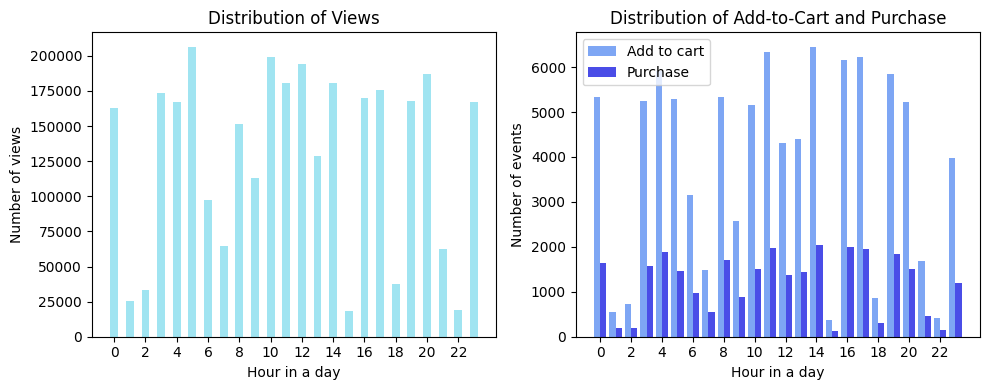

In [22]:
%%time
import numpy as np
import matplotlib.pyplot as plt

# plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
ind = np.arange(event_by_hour_df.index.min(), event_by_hour_df.index.max()+1)
width = 0.5
view_bar = ax1.bar(ind, event_by_hour_df.view, width=width, color='#A0E4F1')
ax1.set_xticks(ind)
ax1.set_xticks(ax1.get_xticks()[::2])
ax1.set_xlabel("Hour in a day")
ax1.set_ylabel("Number of views")
ax1.set_title("Distribution of Views")

width = 0.4
cart_bar = ax2.bar(ind, event_by_hour_df.cart, width=width, color='#7EA6F4')
purchase_bar = ax2.bar(ind+width, event_by_hour_df.purchase, width=width, color='#4A4DE7')
ax2.set_xticks(ind+width/2)
ax2.set_xticks(ax2.get_xticks()[::2])
ax2.set_xticklabels(ind[::2])
ax2.set_xlabel("Hour in a day")
ax2.set_ylabel("Number of events")
ax2.set_title("Distribution of Add-to-Cart and Purchase")
ax2.legend((cart_bar, purchase_bar), ('Add to cart', 'Purchase'))
fig.tight_layout()

## 알게 된 것
  * 시간별 View 개수
    * 새벽 2시가 제일 높고, 20시 이후도 꽤 높다.
    * 새벽 5시가 낮다. 다들 자는 것일까?
    * 점심시간 전/후로 View 개수가 제일 낮다. 점심 시간대에는 다시 높아진다.
    * 오후 업무시간대 중 15시를 제외하면 View 개수가 낮다.

  * 장바구니 담기와 구매
    * 장바구니에 담은 것이 모두 구매로 이어지지 않는다.
    * 새벽 시간대가 의외로 구매가 높다.
    * 점심시간 전/후로는 구매가 적다.
    * 퇴근 시간 전 업무시간도 구매가 적다.
    * 20시 이후에 구매가 갑자기 증가한다.

# 2. Daily distribution of number of events, by time session

In [23]:
%%time
view_by_time_session = df_smartphone.filter(df_smartphone.event_type == 'view').groupby("time_session").agg(count("event_type").alias('view'))
cart_by_time_session = df_smartphone.filter(df_smartphone.event_type == 'cart').groupby("time_session").agg(count("event_type").alias('cart'))
purchase_by_time_session = df_smartphone.filter(df_smartphone.event_type == 'purchase').groupby("time_session").agg(count("event_type").alias('purchase'))
event_by_time_session = view_by_time_session.join(cart_by_time_session, 'time_session').join(purchase_by_time_session, 'time_session')

event_by_time_session_df = event_by_time_session.toPandas()
event_by_time_session_df

CPU times: user 344 ms, sys: 40.2 ms, total: 385 ms
Wall time: 52.8 s


,time_session,view,cart,purchase
0,12-15,523473,15805,4728
1,21-24,81663,1779,621
2,15-18,599913,14765,4363
3,18-21,344204,8020,2630
4,0-3,115025,2845,804
5,9-12,523443,18405,5748
6,3-6,377456,12899,4129
7,6-9,517375,18524,5939


CPU times: user 312 ms, sys: 96.1 ms, total: 408 ms
Wall time: 516 ms


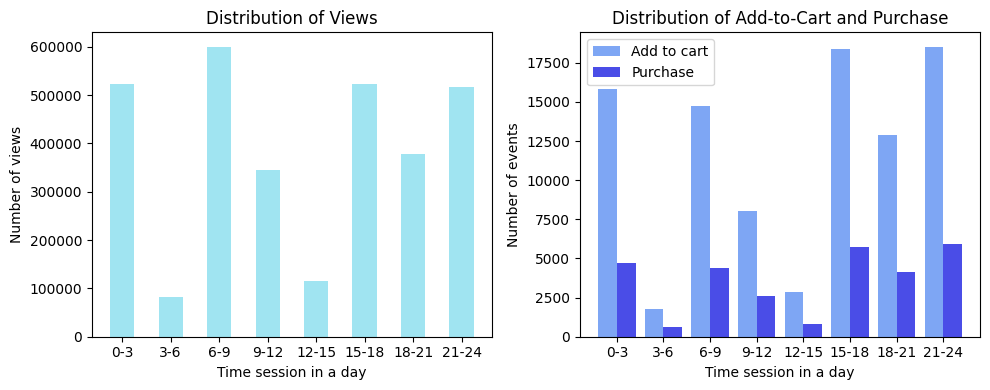

In [24]:
%%time
# plot
session_labels = ['0-3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21', '21-24']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ind = np.arange(event_by_time_session_df.index.nunique())
width = 0.5
ax1.bar(ind, event_by_time_session_df.view, width=width, color='#A0E4F1')
ax1.set_xticks(ind)
ax1.set_xticklabels(session_labels)
ax1.set_xlabel("Time session in a day")
ax1.set_ylabel("Number of views")
ax1.set_title("Distribution of Views")

width = 0.4
cart_bar = ax2.bar(ind, event_by_time_session_df.cart, width=width, color='#7EA6F4')
purchase_bar = ax2.bar(ind+width, event_by_time_session_df.purchase, width=width, color='#4A4DE7')
ax2.set_xticks(ind+width/2)
ax2.set_xticklabels(session_labels)
ax2.set_xlabel("Time session in a day")
ax2.set_ylabel("Number of events")
ax2.set_title("Distribution of Add-to-Cart and Purchase")
ax2.legend((cart_bar, purchase_bar), ('Add to cart', 'Purchase'))
fig.tight_layout()

## 알게 된 것
  * 시간대별(3시간 단위) View 개수
    * 새벽 시간대에 View는 점심 이후 시간대만큼 많이 본다.
    * 저녁식사 시간대에 View가 적다.
    * 보통 사람들이 자기 전에 View가 적다.
* 시간대별 장바구니 담기와 구매 개수
  * 새벽시간 대에 구매하는 비율이 압도적이다.
  * 오전에도 장바구니에 담는 것이 많다.
  * 저녁식사 시간 이후에는 View도 적으며, 구매도 적어진다.
  

CPU times: user 62.5 ms, sys: 0 ns, total: 62.5 ms
Wall time: 67.5 ms


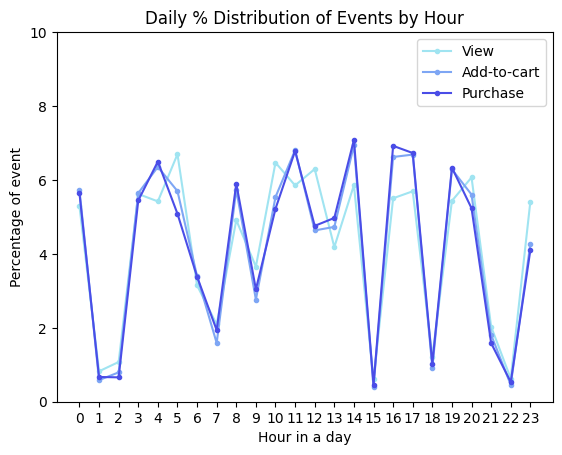

In [25]:
%%time
# combination showing ratio
event_by_hour_df['view_pct'] = event_by_hour_df.view / sum(event_by_hour_df.view) * 100
event_by_hour_df['cart_pct'] = event_by_hour_df.cart/ sum(event_by_hour_df.cart) * 100
event_by_hour_df['purchase_pct'] = event_by_hour_df.purchase / sum(event_by_hour_df.purchase) * 100

hours = np.arange(0, 24)
view_pct_hr = plt.plot(event_by_hour_df.index, event_by_hour_df.view_pct, marker='.', color='#A0E4F1', label='View')
cart_pct_hr = plt.plot(event_by_hour_df.index, event_by_hour_df.cart_pct, marker='.', color='#7EA6F4', label='Add-to-cart')
purchase_pct_hr = plt.plot(event_by_hour_df.index, event_by_hour_df.purchase_pct, marker='.', color='#4A4DE7', label='Purchase')
plt.xticks(hours)
plt.ylim([0, 10])
plt.xlabel("Hour in a day")
plt.ylabel("Percentage of event")
plt.title("Daily % Distribution of Events by Hour")
plt.legend()

## 알게 된 것
  * 시간별 이벤트
    * 일반적으로 자기 전에 구매보다는 View를 많이 하는 듯 하다.
    * 새벽시간 ~ 오전에 구매를 많이 한다.

CPU times: user 48.7 ms, sys: 520 µs, total: 49.2 ms
Wall time: 55.9 ms


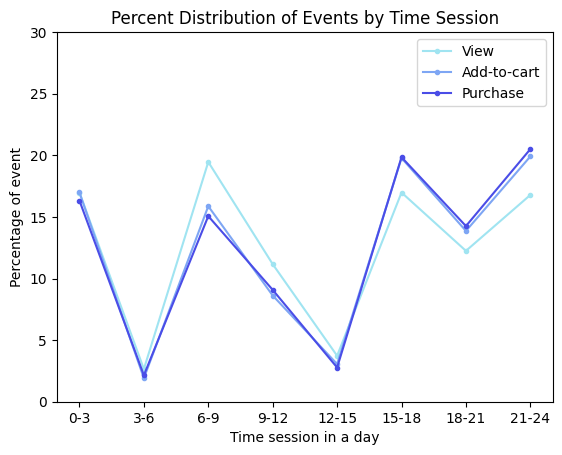

In [26]:
%%time
# combination showing ratio
event_by_time_session_df['view_pct'] = event_by_time_session_df.view / sum(event_by_time_session_df.view) * 100
event_by_time_session_df['cart_pct'] = event_by_time_session_df.cart/ sum(event_by_time_session_df.cart) * 100
event_by_time_session_df['purchase_pct'] = event_by_time_session_df.purchase / sum(event_by_time_session_df.purchase) * 100

time_sessions = np.arange(0, len(session_labels))
view_pct_ss = plt.plot(event_by_time_session_df.index, event_by_time_session_df.view_pct, marker='.', color='#A0E4F1', label='View')
cart_pct_ss = plt.plot(event_by_time_session_df.index, event_by_time_session_df.cart_pct, marker='.', color='#7EA6F4', label='Add-to-cart')
purchase_pct_ss = plt.plot(event_by_time_session_df.index, event_by_time_session_df.purchase_pct, marker='.', color='#4A4DE7', label='Purchase')
plt.xticks(time_sessions, session_labels)
plt.ylim([0, 30])
plt.xlabel("Time session in a day")
plt.ylabel("Percentage of event")
plt.title("Percent Distribution of Events by Time Session")
plt.legend()

## 알게 된 것
  * 새벽~ 오전에는 구매를 더 많이 한다.
  * 점심시간 ~ 자기 전까지는 View를 많이 한다.

# 3. Daily distribution of events, facet by weekday

In [27]:
%%time
import pandas as pd

weekdays = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
weekday_dict = dict(zip(weekdays, list(range(1,8))))

view_by_ss_wkdy = df_smartphone.filter(df_smartphone.event_type == 'view').groupby(['weekday', 'time_session']).agg(count("event_type").alias('num_view')).toPandas()
view_by_ss_wkdy['weekday'] = view_by_ss_wkdy['weekday'].apply(lambda x: weekdays[x-1])
view_by_ss_wkdy['weekday'] = pd.Categorical(view_by_ss_wkdy.weekday, categories=weekdays, ordered=True)
view_by_ss_wkdy['time_session'] = pd.Categorical(view_by_ss_wkdy.time_session, categories=session_labels, ordered=True)
view_by_ss_wkdy.sort_values(by=['weekday', 'time_session'], inplace=True)

cart_by_ss_wkdy = df_smartphone.filter(df_smartphone.event_type == 'cart').groupby(['weekday', 'time_session']).agg(count("event_type").alias('num_cart')).toPandas()
cart_by_ss_wkdy['weekday'] = cart_by_ss_wkdy['weekday'].apply(lambda x: weekdays[x-1])
cart_by_ss_wkdy['weekday'] = pd.Categorical(cart_by_ss_wkdy.weekday, categories=weekdays, ordered=True)
cart_by_ss_wkdy['time_session'] = pd.Categorical(cart_by_ss_wkdy.time_session, categories=session_labels, ordered=True)
cart_by_ss_wkdy.sort_values(by=['weekday', 'time_session'], inplace=True)

purchase_by_ss_wkdy = df_smartphone.filter(df_smartphone.event_type == 'purchase').groupby(['weekday', 'time_session']).agg(count("event_type").alias('num_purchase')).toPandas()
purchase_by_ss_wkdy['weekday'] = purchase_by_ss_wkdy['weekday'].apply(lambda x: weekdays[x-1])
purchase_by_ss_wkdy['weekday'] = pd.Categorical(purchase_by_ss_wkdy.weekday, categories=weekdays, ordered=True)
purchase_by_ss_wkdy['time_session'] = pd.Categorical(purchase_by_ss_wkdy.time_session, categories=session_labels, ordered=True)
purchase_by_ss_wkdy.sort_values(by=['weekday', 'time_session'], inplace=True)

purchase_by_ss_wkdy.head(8)

CPU times: user 307 ms, sys: 40.8 ms, total: 348 ms
Wall time: 30.8 s


,weekday,time_session,num_purchase
31,Sunday,0-3,97
26,Sunday,3-6,552
34,Sunday,6-9,892
38,Sunday,9-12,827
21,Sunday,12-15,655
39,Sunday,15-18,667
4,Sunday,18-21,415
27,Sunday,21-24,79


In [28]:
%%time
# events per weekday
view_per_wkdy = view_by_ss_wkdy.groupby("weekday")['num_view'].sum().to_frame()
cart_per_wkdy = cart_by_ss_wkdy.groupby("weekday")['num_cart'].sum().to_frame()
purchase_per_wkdy = purchase_by_ss_wkdy.groupby("weekday")['num_purchase'].sum().to_frame()
event_by_weekday = pd.concat([view_per_wkdy, cart_per_wkdy, purchase_per_wkdy], axis=1)
event_by_weekday

CPU times: user 6.57 ms, sys: 862 µs, total: 7.43 ms
Wall time: 10.7 ms


,num_view,num_cart,num_purchase
weekday,,,
Sunday,450135,13607,4184
Monday,446807,13694,4238
Tuesday,449554,12943,4099
Wednesday,450989,13281,4358
Thursday,444840,13160,4205
Friday,412010,13054,3974
Saturday,428217,13303,3904


CPU times: user 71.3 ms, sys: 0 ns, total: 71.3 ms
Wall time: 71.7 ms


Text(0.5, 1.0, 'Weekly Distribution of Events')

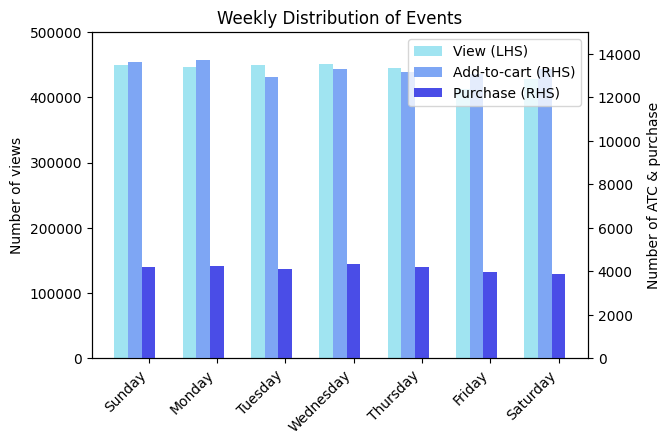

In [29]:
%%time
# plot events per weekday
fig, ax1 = plt.subplots()

width = 0.2
xticks = np.arange(0, len(weekdays))

view_wkdy_plot = ax1.bar(xticks, event_by_weekday.num_view, width=width, color='#A0E4F1')
ax1.set_ylim([0, 500_000])
ax1.set_ylabel("Number of views")

ax2 = ax1.twinx()
cart_wkdy_plot = ax2.bar(xticks+width, event_by_weekday.num_cart, width=width, color='#7EA6F4')
purchase_wkdy_plot = ax2.bar(xticks+width*2, event_by_weekday.num_purchase, width=width, color='#4A4DE7')
ax2.set_ylim([0, 15_000])
ax2.set_ylabel("Number of ATC & purchase")

plt.legend((view_wkdy_plot, cart_wkdy_plot, purchase_wkdy_plot), ('View (LHS)', 'Add-to-cart (RHS)', 'Purchase (RHS)'))
plt.xticks(xticks+width*2, weekdays)
fig.autofmt_xdate(rotation=45)
plt.title('Weekly Distribution of Events')

## 알게 된 것
  * 장난감은 요일에 상관없이 꾸준히 구매한다.

CPU times: user 546 ms, sys: 135 ms, total: 681 ms
Wall time: 586 ms


array([[<Axes: title={'center': 'Sunday'}, xlabel='Time session'>,
        <Axes: title={'center': 'Monday'}, xlabel='Time session'>,
        <Axes: title={'center': 'Tuesday'}, xlabel='Time session'>],
       [<Axes: title={'center': 'Wednesday'}, xlabel='Time session'>,
        <Axes: title={'center': 'Thursday'}, xlabel='Time session'>,
        <Axes: title={'center': 'Friday'}, xlabel='Time session'>],
       [<Axes: title={'center': 'Saturday'}, xlabel='Time session'>,
        <Axes: xlabel='Time session'>, <Axes: xlabel='Time session'>]],
      dtype=object)

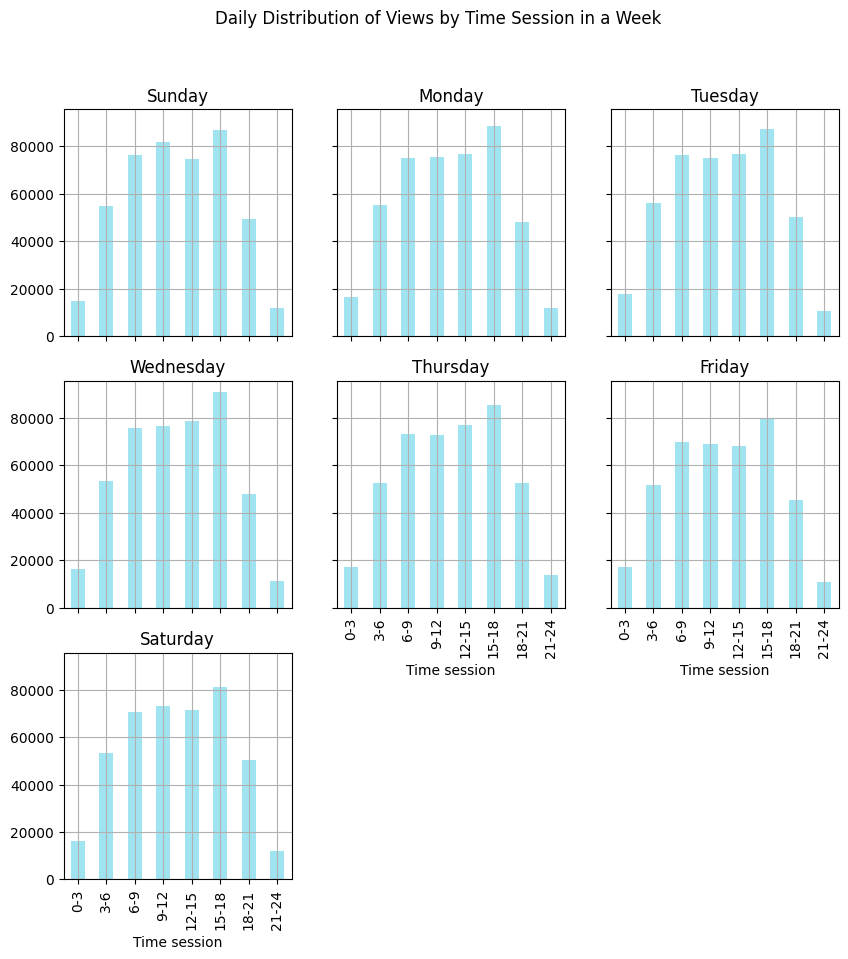

In [30]:
%%time
# Daily split
view_by_ss_wkdy_pvt = view_by_ss_wkdy.pivot(index='weekday', columns='time_session', values='num_view')
view_by_ss_wkdy_pvt.T.plot.bar(
    subplots=True,
    layout=(3,3),
    figsize=(10, 10),
    color='#A0E4F1',
    sharex=True,
    sharey=True,
    legend=False,
    xlabel='Time session',
    title='Daily Distribution of Views by Time Session in a Week',
    grid=True
)

CPU times: user 743 ms, sys: 81.2 ms, total: 825 ms
Wall time: 760 ms


array([[<Axes: title={'center': 'Sunday'}, xlabel='Time session'>,
        <Axes: title={'center': 'Monday'}, xlabel='Time session'>,
        <Axes: title={'center': 'Tuesday'}, xlabel='Time session'>],
       [<Axes: title={'center': 'Wednesday'}, xlabel='Time session'>,
        <Axes: title={'center': 'Thursday'}, xlabel='Time session'>,
        <Axes: title={'center': 'Friday'}, xlabel='Time session'>],
       [<Axes: title={'center': 'Saturday'}, xlabel='Time session'>,
        <Axes: xlabel='Time session'>, <Axes: xlabel='Time session'>]],
      dtype=object)

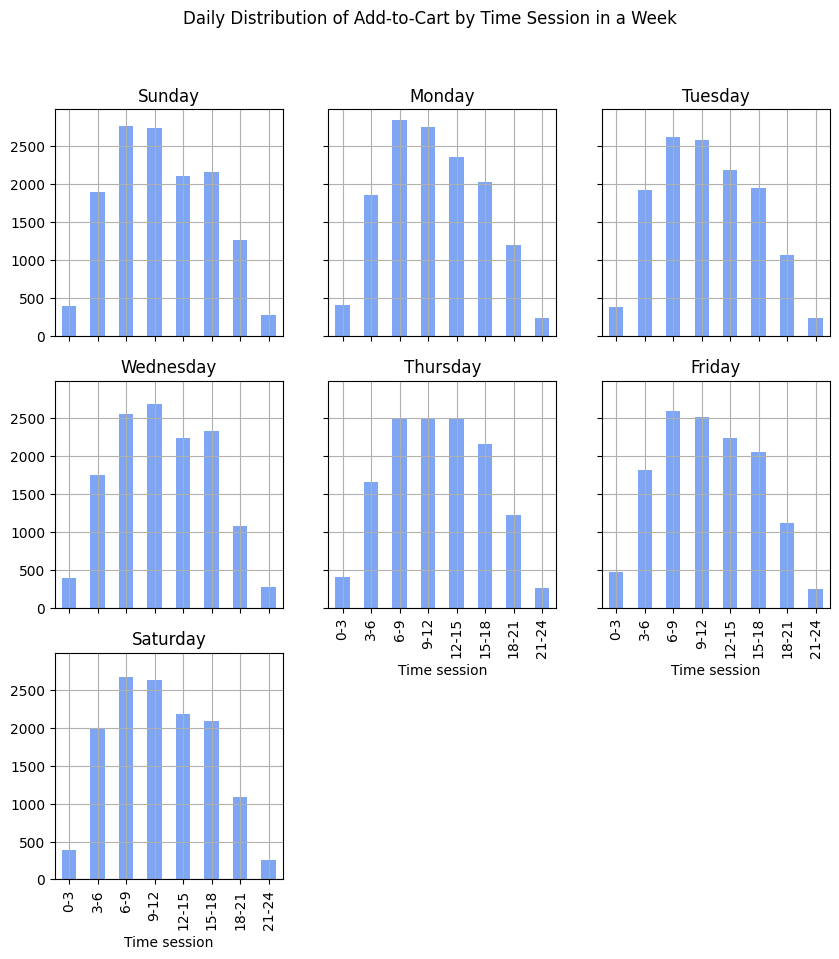

In [31]:
%%time
# Daily split
cart_by_ss_wkdy_pvt = cart_by_ss_wkdy.pivot(index='weekday', columns='time_session', values='num_cart')
cart_by_ss_wkdy_pvt.T.plot.bar(
    subplots=True,
    layout=(3,3),
    figsize=(10, 10),
    color='#7EA6F4',
    sharex=True,
    sharey=True,
    legend=False,
    xlabel='Time session',
    title='Daily Distribution of Add-to-Cart by Time Session in a Week',
    grid=True
)

CPU times: user 520 ms, sys: 118 ms, total: 638 ms
Wall time: 528 ms


array([[<Axes: title={'center': 'Sunday'}, xlabel='Time session'>,
        <Axes: title={'center': 'Monday'}, xlabel='Time session'>,
        <Axes: title={'center': 'Tuesday'}, xlabel='Time session'>],
       [<Axes: title={'center': 'Wednesday'}, xlabel='Time session'>,
        <Axes: title={'center': 'Thursday'}, xlabel='Time session'>,
        <Axes: title={'center': 'Friday'}, xlabel='Time session'>],
       [<Axes: title={'center': 'Saturday'}, xlabel='Time session'>,
        <Axes: xlabel='Time session'>, <Axes: xlabel='Time session'>]],
      dtype=object)

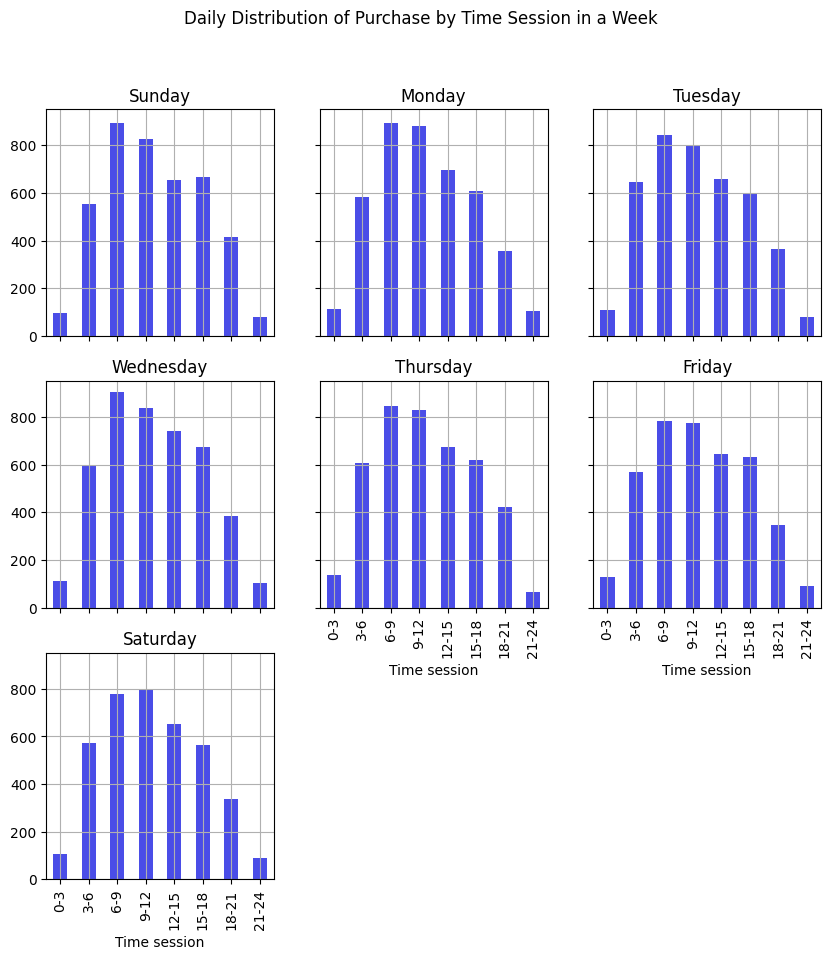

In [32]:
%%time
# Daily split
purchase_by_ss_wkdy_pvt = purchase_by_ss_wkdy.pivot(index='weekday', columns='time_session', values='num_purchase')
purchase_by_ss_wkdy_pvt.T.plot.bar(
    subplots=True,
    layout=(3,3),
    figsize=(10, 10),
    color='#4A4DE7',
    sharex=True,
    sharey=True,
    legend=False,
    xlabel='Time session',
    title='Daily Distribution of Purchase by Time Session in a Week',
    grid=True
)

## 알게 된 것
  * 장난감은 요일에 상관 없이 구매한다.


# 4. Hypo testing with Chi-square test

### $H_0$: 쇼핑하는 사람들은 보기/장바구니 담기/구매에 대한 선호 시간이 있다.

In [33]:
def chi2_test(obs, exp, main_cat: int = 0, alpha = 0.05):
    from scipy.stats import chisquare

    chi, pval = chisquare(f_obs=obs, f_exp=exp)
    if pval < alpha:
        print(f"Statistically significant under level of sig={alpha} ({pval}). H0 rejected.")
    else:
        print(f"NOT statistically significant under level of sig={alpha} ({pval}). H0 not rejected.")

    return chi, pval

In [34]:
%%time
def half_of_day(x):
    return 2 if x > 12 else 1

half_of_day_udf = udf(half_of_day)

df_smartphone = df_smartphone.withColumn("half_of_day", half_of_day_udf("hour"))

def event_retype(x):
    return 2 if x in ['cart', 'purchase'] else 1

event_retype_udf = udf(event_retype)

df_smartphone = df_smartphone.withColumn("event_retype", event_retype_udf("event_type"))

CPU times: user 7.59 ms, sys: 3.12 ms, total: 10.7 ms
Wall time: 73.5 ms


In [35]:
%%time
data_test_psdf = df_smartphone[["half_of_day", "event_retype"]]
data_test_pd = data_test_psdf.toPandas()

CPU times: user 17.9 s, sys: 1.76 s, total: 19.7 s
Wall time: 1min 5s


In [36]:
%%time
chi_crosstab = pd.crosstab(data_test_pd.half_of_day, data_test_pd.event_retype, margins=True)
chi_crosstab

CPU times: user 2.23 s, sys: 562 ms, total: 2.79 s
Wall time: 2.8 s


event_retype,1,2,All
half_of_day,,,
1,1696446,76266,1772712
2,1386106,45738,1431844
All,3082552,122004,3204556


In [37]:
%%time
obs = chi_crosstab.iloc[0, :]
exp = chi_crosstab.iloc[1, :]

obs = obs*exp.sum()/obs.sum() # for matching counts

pval, chi = chi2_test(obs, exp)

Statistically significant under level of sig=0.05 (0.0). H0 rejected.
CPU times: user 475 ms, sys: 148 ms, total: 623 ms
Wall time: 1.08 s


### $H_0$ 기각
  * 쇼핑하는 사람들은 시간과 상관 없이 보기, 장바구니 담기, 구매를 한다.

In [38]:
%%time
data_test_psdf = df_smartphone[["weekday", "event_retype"]]
data_test_pd = data_test_psdf.toPandas()

CPU times: user 15.1 s, sys: 777 ms, total: 15.9 s
Wall time: 48.4 s


In [39]:
%%time
chi_ctab_wk = pd.crosstab(data_test_pd.weekday, data_test_pd.event_retype, margins=True)
chi_ctab_wk

CPU times: user 2.53 s, sys: 285 ms, total: 2.81 s
Wall time: 2.91 s


event_retype,1,2,All
weekday,,,
1,450135,17791,467926
2,446807,17932,464739
3,449554,17042,466596
4,450989,17639,468628
5,444840,17365,462205
6,412010,17028,429038
7,428217,17207,445424
All,3082552,122004,3204556


In [40]:
%%time
pval, chi = chi2_test(chi_ctab_wk.iloc[:-1, 0] * (chi_ctab_wk.iloc[:-1, 1].sum()/chi_ctab_wk.iloc[:-1, 0].sum()), chi_ctab_wk.iloc[:-1, 1])

Statistically significant under level of sig=0.05 (1.6071244060066745e-14). H0 rejected.
CPU times: user 4.18 ms, sys: 17 µs, total: 4.19 ms
Wall time: 4.73 ms


### $H_0$ 기각
  * 요일은 보기/장바구니 담기/구매와 관계 없이 발생한다.

Conclusion: shoppers have different time preference for viewing vs. ATC & check-outs when shopping on e-comm platform.

# 5. Add-to-cart rate (ATCR) and cart abandonment rate

In [41]:
%%time
import pyspark.pandas as ps

data_test = df_smartphone.to_pandas_on_spark()

user_session_by_time_session = data_test.drop_duplicates(subset=['user_session']).groupby("time_session")['user_session'].count()\
    .to_frame().rename(columns={"user_session": "num_user_session"})
user_session_by_time_session.head()

/content/spark-3.2.4-bin-hadoop3.2/python/pyspark/pandas/__init__.py:47: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


CPU times: user 364 ms, sys: 27.3 ms, total: 392 ms
Wall time: 1.8 s


,num_user_session
time_session,
12-15,210608
21-24,30770
15-18,223144
18-21,132533
0-3,48924


In [42]:
%%time
cart_sessions = data_test[data_test.event_type == 'cart']
user_session_cart_by_time_session = cart_sessions.groupby("time_session")['user_session'].count()\
    .to_frame().rename(columns={"user_session": "num_user_session_cart"})
user_session_cart_by_time_session.head()

CPU times: user 55.2 ms, sys: 10.2 ms, total: 65.5 ms
Wall time: 389 ms


,num_user_session_cart
time_session,
12-15,15805
21-24,1779
15-18,14765
18-21,8020
0-3,2845


In [43]:
%%time
ps.set_option('compute.ops_on_diff_frames', True) # only needed for pyspark pandas

atcr_by_time_session = ps.concat([user_session_by_time_session, user_session_cart_by_time_session], axis=1)
atcr_by_time_session['atcr'] = atcr_by_time_session.num_user_session_cart / atcr_by_time_session.num_user_session * 100
atcr_by_time_session.head()

CPU times: user 54.4 ms, sys: 5.54 ms, total: 59.9 ms
Wall time: 439 ms


,num_user_session,num_user_session_cart,atcr
time_session,,,
0-3,48924,2845,5.815142
12-15,210608,15805,7.504463
15-18,223144,14765,6.616803
18-21,132533,8020,6.051323
21-24,30770,1779,5.781605


In [44]:
%%time
purchase_sessions = data_test[data_test.event_type == 'purchase']
user_session_purchase_by_time_session = purchase_sessions.groupby("time_session")['user_session'].count()\
    .to_frame().rename(columns={"user_session": "num_user_session_purchase"})
user_session_purchase_by_time_session.head()

CPU times: user 60.8 ms, sys: 4.07 ms, total: 64.8 ms
Wall time: 485 ms


,num_user_session_purchase
time_session,
12-15,4728
21-24,621
15-18,4363
18-21,2630
0-3,804


In [45]:
%%time
ctcr_by_time_session = ps.concat([user_session_cart_by_time_session, user_session_purchase_by_time_session], axis=1)
ctcr_by_time_session['ctcr'] = ctcr_by_time_session.num_user_session_purchase / ctcr_by_time_session.num_user_session_cart * 100
ctcr_by_time_session.head()

CPU times: user 69.5 ms, sys: 7.18 ms, total: 76.7 ms
Wall time: 1.25 s


,num_user_session_cart,num_user_session_purchase,ctcr
time_session,,,
0-3,2845,804,28.260105
12-15,15805,4728,29.914584
15-18,14765,4363,29.549611
18-21,8020,2630,32.793017
21-24,1779,621,34.907251


In [46]:
%%time
ctcr_by_time_session['car'] = 100 - ctcr_by_time_session.ctcr
ctcr_by_time_session

CPU times: user 7.39 ms, sys: 1.94 ms, total: 9.33 ms
Wall time: 100 ms


,num_user_session_cart,num_user_session_purchase,ctcr,car
time_session,,,,
0-3,2845,804,28.260105,71.739895
12-15,15805,4728,29.914584,70.085416
15-18,14765,4363,29.549611,70.450389
18-21,8020,2630,32.793017,67.206983
21-24,1779,621,34.907251,65.092749
3-6,12899,4129,32.010233,67.989767
6-9,18524,5939,32.061110,67.938890
9-12,18405,5748,31.230644,68.769356


CPU times: user 484 ms, sys: 89.2 ms, total: 574 ms
Wall time: 40.6 s


([<matplotlib.axis.XTick at 0x7b942f0e1a80>,
 [Text(0, 0, '0-3'),
  Text(1, 0, '3-6'),
  Text(2, 0, '6-9'),
  Text(3, 0, '9-12'),
  Text(4, 0, '12-15'),
  Text(5, 0, '15-18'),
  Text(6, 0, '18-21'),
  Text(7, 0, '21-24')])

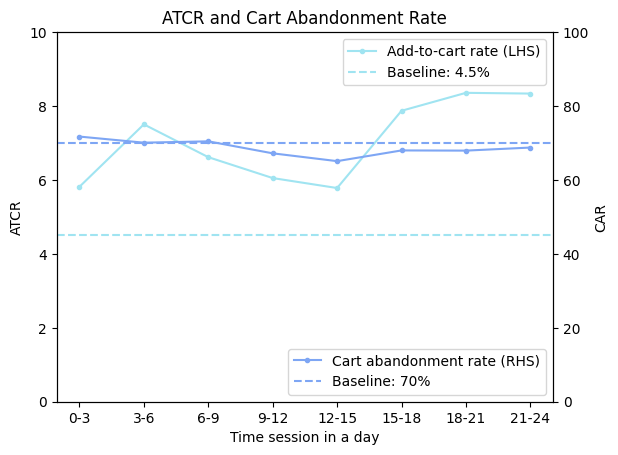

In [47]:
%%time
# visualization
fig, ax1 = plt.subplots()

avg_atcr = 4.5
ax1.plot(atcr_by_time_session.index, atcr_by_time_session.atcr, marker='.', color='#A0E4F1', label='Add-to-cart rate (LHS)')
ax1.axhline(y=avg_atcr, linestyle='--', color='#A0E4F1', linewidth=1.5, label=f'Baseline: {avg_atcr}%')
# ax1.set_ylim([0, 8])
ax1.set_ylim([0, 10])
ax1.set_xlabel("Time session in a day")
ax1.set_ylabel("ATCR")
ax1.legend(loc="upper right")

ax2 = ax1.twinx()
ax2.plot(ctcr_by_time_session.index, ctcr_by_time_session.car, marker='.', color='#7EA6F4', label='Cart abandonment rate (RHS)')
ax2.axhline(y=70, linestyle='--', color='#7EA6F4', linewidth=1.5, label='Baseline: 70%')
ax2.set_ylim([0, 100])
ax2.set_ylabel("CAR")
ax2.legend(loc="lower right")

plt.title("ATCR and Cart Abandonment Rate")
plt.xticks(time_sessions, session_labels)

##알게 된 것
  * 장바구니에 담은 것은 시간대에 상관 없이 사지 않는다.
  * 장바구니에 담는 것은 새벽~오후 시간대에 많다.

Time interval between each decision to act

In [48]:
%%time
from pyspark.sql.functions import concat

df_test = df_smartphone.limit(20000).cache()

df_test = df_test.withColumn("product_id", df_test.product_id.cast('string'))
df_test = df_test.withColumn("category_id", df_test.category_id.cast('string'))
df_test = df_test.withColumn("user_id", df_test.user_id.cast('string'))

max_id_len = df_test.withColumn("product_id_len", length(col("product_id")))\
                    .withColumn("category_id_len", length(col("category_id")))\
                    .withColumn("user_id_len", length(col("user_id")))\
                    .groupBy().agg(max("product_id_len"), max("category_id_len"), max("user_id_len")).collect()

len_pid, len_cid, len_uid = max_id_len[0]

df_test = df_test.withColumn("product_id", lpad(df_test.product_id, len_pid, '0'))\
                 .withColumn("category_id", lpad(df_test.category_id, len_cid, '0'))\
                 .withColumn("user_id", lpad(df_test.user_id, len_uid, '0'))

df_test = df_test.withColumn("uid", concat(col("user_id"), col("brand"), col("product_id")))
uid_view = df_test.filter(df_test.event_type == 'view').select("uid").distinct()
uid_cart = df_test.filter(df_test.event_type == 'cart').select("uid").distinct()
uid_purchase = df_test.filter(df_test.event_type == 'purchase').select("uid").distinct()

uid_common = uid_view.intersect(uid_cart).intersect(uid_purchase).collect()
uid_common = [ u.uid for u in uid_common ]
len(uid_common)

CPU times: user 64.7 ms, sys: 6.89 ms, total: 71.5 ms
Wall time: 5 s


1

## 알게 된 것
* 상품 보는 사람과 구매하는 사람은 다르다.
* 상품을 본 사람과 장바구니에 담아 구매하는 사람은 다른 사람이다?

Filter userid+productid+brand with all three events (view-cart-purchase, with purchase being the end)

Calculate number of sessions between first view to end purchase. What’s the average user session numbers before a customer place an order?

Calculate the time gap between decisions: a) First view – ATC b) ATC – purchase What’s the average time interval between each decision? May use box plot

Calculate the price change from first view, ATC and final payment. Is there any price changes that possibly affect consumer’s decision to buy?

Brand analysis (simply)

In [49]:
%%time
data_filtered = df_test.filter(df_test.uid.isin(uid_common))
print((data_filtered.count(), len(data_filtered.columns)))

(8, 18)
CPU times: user 6.3 ms, sys: 1.72 ms, total: 8.02 ms
Wall time: 232 ms


## 알게 된 것
* 상품 조회부터 구매까지 모두 다 한 사람은 없다.

In [50]:
%%time
from datetime import timedelta

def dt64_to_dt(datetime64):
    return datetime.utcfromtimestamp(datetime64.tolist()/1e9)

header = [
            'uid',
            'time_view_to_cart',
            'cart_duration',
            'time_cart_to_purchase',
            'time_view_to_purchase',
            'num_user_sessions',
            'price_change_view_to_cart',
            'price_change_cart_to_purchase'
            ]

interval_df = pd.DataFrame(columns=header)

for i in uid_common:
    data_selected = data_filtered.filter(data_filtered.uid == i).sort("event_time").toPandas()
    purchase_index = data_selected[data_selected.event_type == 'purchase'].index[-1]
    data_selected = data_selected.loc[:purchase_index, :]

    # time gap
    try:
        time_view = dt64_to_dt(data_selected[data_selected.event_type == 'view'].drop_duplicates(subset=['event_type'], keep='first')\
            .event_time.astype(np.datetime64).values[0])
    except IndexError:
        time_view = np.nan

    try:
        time_cart_first = dt64_to_dt(data_selected[data_selected.event_type == 'cart'].drop_duplicates(subset=['event_type'], keep='first')\
            .event_time.astype(np.datetime64).values[0])
    except IndexError:
        time_cart_first = np.nan

    try:
        time_cart_final = dt64_to_dt(data_selected[data_selected.event_type == 'cart'].drop_duplicates(subset=['event_type'], keep='last')\
            .event_time.astype(np.datetime64).values[0])
    except IndexError:
        time_cart_final = np.nan

    try:
        time_purchase = dt64_to_dt(data_selected[data_selected.event_type == 'purchase'].drop_duplicates(subset=['event_type'], keep='first')\
            .event_time.astype(np.datetime64).values[0])
    except IndexError:
        time_purchase = np.nan

    try:
        cart_duration = timedelta.Timedelta(time_cart_final - time_cart_first).total.seconds
    except (AttributeError, TypeError):
        cart_duration = np.nan

    try:
        view_to_cart = timedelta.Timedelta(time_cart_first - time_view).total.seconds
    except (AttributeError, TypeError):
        view_to_cart = np.nan

    try:
        cart_to_purchase = timedelta.Timedelta(time_purchase - time_cart_final).total.seconds
    except (AttributeError, TypeError):
        cart_to_purchase = np.nan

    try:
        view_to_purchase = timedelta.Timedelta(time_purchase - time_view).total.seconds
    except (AttributeError, TypeError):
        view_to_purchase = np.nan

    # user session gap
    user_session_gap = data_selected.user_session.nunique()

    # price change
    try:
        price_view = data_selected[data_selected.event_type == 'view'].drop_duplicates(subset=['event_type'], keep='first').price.values[0]
    except IndexError:
        price_view = np.nan

    try:
        price_cart = data_selected[data_selected.event_type == 'cart'].drop_duplicates(subset=['event_type'], keep='first').price.values[0]
    except IndexError:
        price_cart = np.nan

    try:
        price_purchase = data_selected[data_selected.event_type == 'purchase'].drop_duplicates(subset=['event_type'], keep='first').price.values[0]
    except IndexError:
        price_purchase = np.nan

    price_change_view_to_cart = price_cart / price_view - 1
    price_change_cart_to_purchase = price_purchase / price_cart - 1

    # combine and append
    record = [
                i,
                view_to_cart,
                cart_duration,
                cart_to_purchase,
                view_to_purchase,
                user_session_gap,
                price_change_view_to_cart,
                price_change_cart_to_purchase
                ]

    interval_df.loc[interval_df.shape[0]] = record

interval_df.head(10)

CPU times: user 80 ms, sys: 8.79 ms, total: 88.7 ms
Wall time: 662 ms


/content/spark-3.2.4-bin-hadoop3.2/python/pyspark/sql/pandas/conversion.py:194: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,uid,time_view_to_cart,cart_duration,time_cart_to_purchase,time_view_to_purchase,num_user_sessions,price_change_view_to_cart,price_change_cart_to_purchase
0,554205255chicco008901605,NaN,NaN,NaN,NaN,2,NaN,NaN


In [51]:
%%time
interval_df = interval_df.reset_index()
interval_df.set_index('uid', inplace=True)
interval_df = interval_df.astype(float).dropna(how='any')
interval_df.describe()

CPU times: user 29.3 ms, sys: 0 ns, total: 29.3 ms
Wall time: 73 ms


,index,time_view_to_cart,cart_duration,time_cart_to_purchase,time_view_to_purchase,num_user_sessions,price_change_view_to_cart,price_change_cart_to_purchase
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
%%time
interval_df_new = interval_df.copy()

cols_to_winsor = ['time_view_to_cart', 'cart_duration', 'time_cart_to_purchase', 'time_view_to_purchase']
time_bound = [300, 120, 300, 900]
for i in range(len(cols_to_winsor)):
    # interval_df_new[col] = mstats.winsorize(interval_df_new[col], limits=[0, 0.15])
    col = cols_to_winsor[i]
    timelim = time_bound[i]
    interval_df_new.loc[interval_df_new[col] > timelim, col] = timelim
    interval_df_new.loc[interval_df_new[col] < 0, col] = 0
interval_df_new.describe()

CPU times: user 30.9 ms, sys: 0 ns, total: 30.9 ms
Wall time: 65.2 ms


,index,time_view_to_cart,cart_duration,time_cart_to_purchase,time_view_to_purchase,num_user_sessions,price_change_view_to_cart,price_change_cart_to_purchase
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


CPU times: user 379 ms, sys: 50.4 ms, total: 429 ms
Wall time: 564 ms


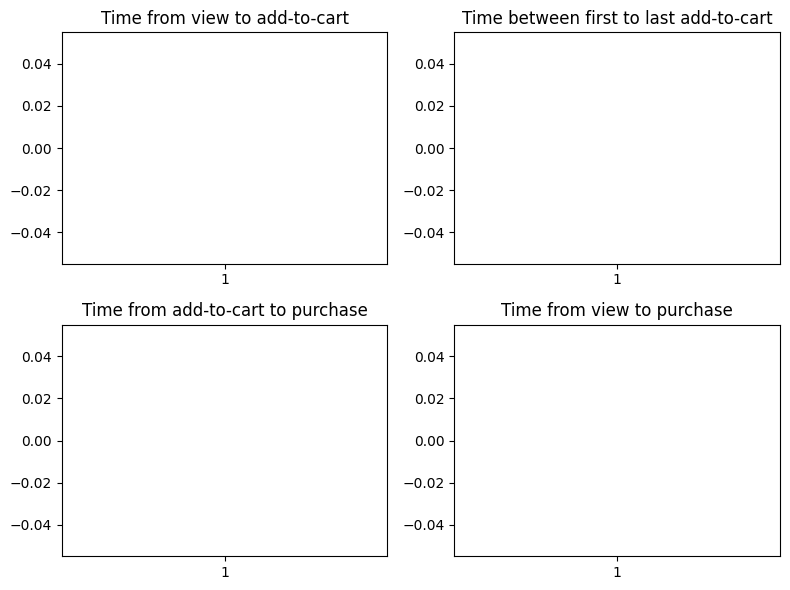

In [53]:
%%time
flierprops = dict(marker='+', markerfacecolor='g', markersize=15, linestyle='none', markeredgecolor='r')
fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot(221)
ax1.boxplot(interval_df_new.time_view_to_cart, flierprops=flierprops)
ax1.set_title('Time from view to add-to-cart')

ax2 = fig.add_subplot(222)
ax2.boxplot(interval_df_new.cart_duration, flierprops=flierprops)
ax2.set_title('Time between first to last add-to-cart')

ax3 = fig.add_subplot(223)
ax3.boxplot(interval_df_new.time_cart_to_purchase, flierprops=flierprops)
ax3.set_title('Time from add-to-cart to purchase')

ax4 = fig.add_subplot(224)
ax4.boxplot(interval_df_new.time_view_to_purchase, flierprops=flierprops)
ax4.set_title('Time from view to purchase')

fig.tight_layout()

Done!

In [54]:
df_smartphone.count()

3204556

# 6. 고선호 브랜드 별 Funnel Analysis

In [55]:
from pyspark.sql.functions import count
# 구매수 별 브랜드 정리 후 purchase, cart, view 로 각각 구분

df_brand = df.filter(df.event_type == 'purchase').groupBy('brand').agg(count("event_type").alias('purchase')).toPandas()
df_brand.sort_values(by='purchase', ascending=False)

df_purchase = df.filter(df.event_type == 'purchase').groupBy("brand").count().toPandas()
df_cart = df.filter(df.event_type == 'cart').groupBy("brand").count().toPandas()
df_view = df.filter(df.event_type == 'view').groupBy("brand").count().toPandas()

In [56]:
df_top10_purchase_brand = df_purchase.sort_values(by='count', ascending=False)
df_top10_purchase_brand = df_top10_purchase_brand.rename(columns={"count": "purchase"})
df_top10_purchase_brand = df_top10_purchase_brand.reset_index(drop=True)
df_top10_purchase_brand = df_top10_purchase_brand.head(10)
df_top10_purchase_brand = pd.DataFrame(df_top10_purchase_brand)
df_top10_purchase_brand

,brand,purchase
0,lucente,9199
1,epson,3592
2,hp,1557
3,rastar,1095
4,escan,986
5,canon,817
6,respect,813
7,hb,753
8,edufun,710
9,adidas,498


In [57]:
df_top10_cart = df_cart.sort_values(by='count', ascending=False)
df_top10_cart = df_top10_cart.rename(columns={"count": "cart"})
df_top10_cart = df_top10_cart.reset_index(drop=True)
df_top10_cart = df_top10_cart.head(10)
df_top10_cart

,brand,cart
0,lucente,19819
1,epson,11174
2,rastar,5769
3,hp,5112
4,hasbro,3436
5,canon,2716
6,escan,2688
7,hb,2532
8,respect,2307
9,edufun,2179


In [58]:
df_top10_view = df_view.sort_values(by='count', ascending=False)
df_top10_view = df_top10_view.rename(columns={"count": "view"})
df_top10_view = df_top10_view.reset_index(drop=True)
df_top10_view = df_top10_view.head(10)
df_top10_view

,brand,view
0,lucente,447552
1,epson,173715
2,defacto,158534
3,rastar,153905
4,hp,132730
5,escan,104616
6,hasbro,100972
7,hb,87905
8,respect,83968
9,adidas,81546


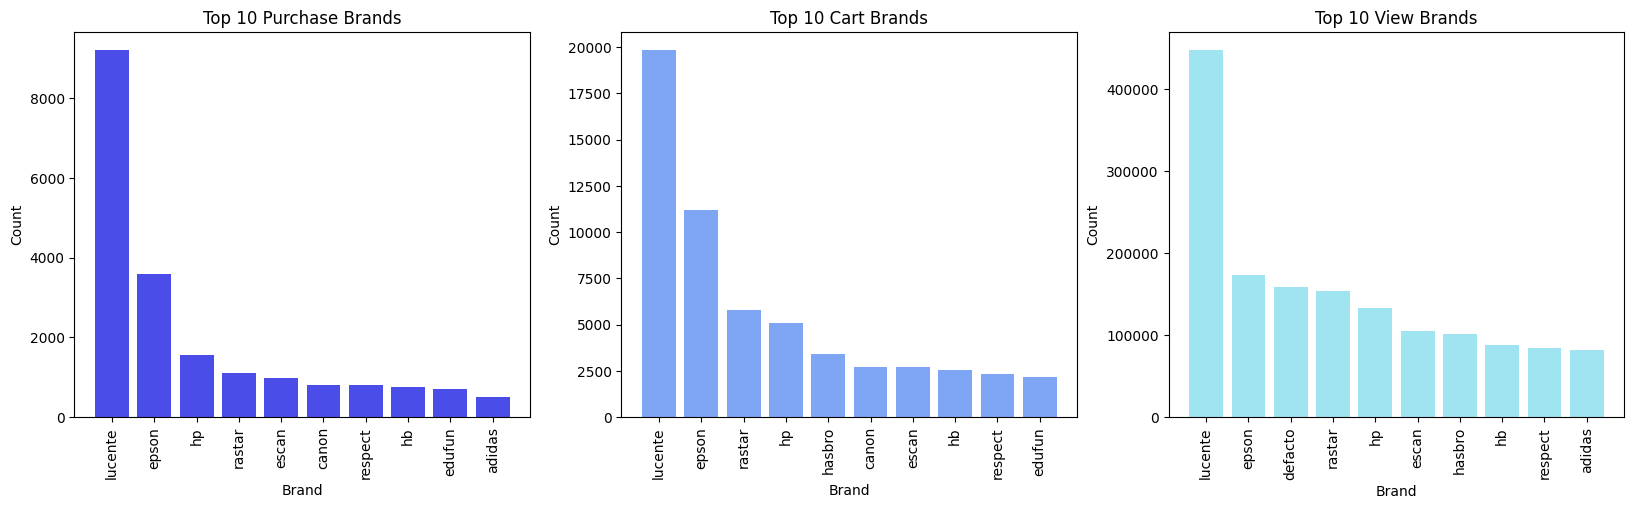

In [59]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(131)
ax1.set_title('Top 10 Purchase Brands')
ax1.set_xlabel('Brand')
ax1.set_ylabel('Count')
ax1.bar(df_top10_purchase_brand.brand, df_top10_purchase_brand['purchase'], color='#4A4DE7')
plt.xticks(rotation=90)

ax2 = fig.add_subplot(132)
ax2.set_title('Top 10 Cart Brands')
ax2.set_xlabel('Brand')
ax2.set_ylabel('Count')
ax2.bar(df_top10_cart.brand, df_top10_cart['cart'], color='#7EA6F4')
plt.xticks(rotation=90)

ax3 = fig.add_subplot(133)
ax3.set_title('Top 10 View Brands')
ax3.set_xlabel('Brand')
ax3.set_ylabel('Count')
ax3.bar(df_top10_view.brand, df_top10_view['view'], color='#A0E4F1')
plt.xticks(rotation=90)

plt.show()

In [60]:
import plotly.express as px

stage = ['view', 'cart', 'purchase']
df_funnel = pd.merge(pd.merge(df_top10_view, df_top10_cart, on='brand'), df_top10_purchase_brand, on='brand')
df_funnel = df_funnel.sort_values('purchase', ascending=False).head(5)
df_funnel['sum'] = df_funnel[stage].sum(axis=1)

df_long = pd.melt(df_funnel, id_vars=['brand', 'sum'], value_vars=stage)

In [61]:
from plotly import graph_objects as go

fig = go.Figure()

for name in df_funnel['brand']:
     fig.add_trace(go.Funnel(
        name = name,
        y = df_long[df_long['brand'] == name].variable,
        x = (df_long[df_long['brand'] == name].value),
        # / (df_long[df_long['brand'] == name]['sum']) * 100,
        textposition = "inside",
        textinfo = "value+percent initial",
        textfont_size=20
        ))

fig.show()

view 대비 cart->purchase의 비중이 매우 낮음을 알 수 있다.
cart->purchase만 별도의 funnel analysis를 수행하면 아래와 같이 나온다.

In [62]:
from plotly import graph_objects as go

fig = go.Figure()
df_long_cp = df_long.query('variable.str.contains("cart|purchase")')

for name in df_funnel['brand']:
     fig.add_trace(go.Funnel(
        name = name,
        y = df_long_cp[df_long['brand'] == name].variable,
        x = df_long_cp[df_long['brand'] == name].value,
        textposition = "inside",
        textinfo = "value+percent initial",
        textfont_size=20
        ))

fig.show()

<ipython-input-62-9044ed3798f6>:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-62-9044ed3798f6>:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

